# 2SFCA script test at Middle Layer Super Output Areas (MSOA) level

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl

In [56]:
import seaborn as sns

# Data import

## Get MSOA boundary data

In [2]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

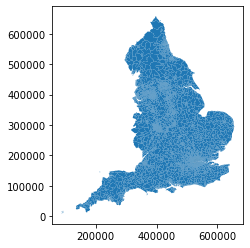

In [3]:
MSOA.plot()

## Get the centroid of MSOA (demand points)

In [4]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

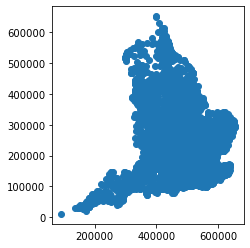

In [5]:
MSOA_points.plot()

In [6]:
MSOA_points

,objectid,msoa11cd,population,geometry
0,1,E02002536,9771,POINT (445582.345 524175.434)
1,2,E02002537,8641,POINT (446777.151 524256.841)
2,3,E02002534,5693,POINT (461356.929 515118.900)
3,4,E02002535,9336,POINT (446117.027 525455.836)
4,5,E02002532,6655,POINT (461053.212 516175.379)
...,...,...,...,...
6786,6787,E02004669,7496,POINT (393469.114 227500.260)
6787,6788,E02006096,7001,POINT (332829.367 109219.836)
6788,6789,E02003088,8444,POINT (343276.340 158947.520)
6789,6790,E02006070,8291,POINT (331710.269 136880.200)


## read vaccination site point data (supply points)

In [7]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

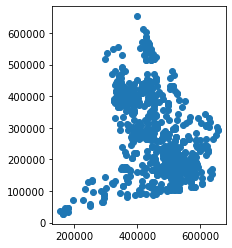

In [8]:
site.plot()

In [9]:
site

,index,supply_value,geometry
0,0,1,POINT (504748.029 248914.642)
1,1,1,POINT (505059.230 222903.988)
2,2,1,POINT (532504.110 176066.629)
3,3,1,POINT (532504.110 176066.629)
4,4,1,POINT (504396.617 222557.941)
...,...,...,...
1595,1595,1,POINT (196928.058 72385.978)
1596,1596,1,POINT (524814.936 172019.963)
1597,1597,1,POINT (526813.753 181129.037)
1598,1598,1,POINT (408626.628 90816.439)


There are 555158 pairs of distances that meet the requirement.

# Read in the driving distance from the point of demand to the point of supply as cost

In [10]:
distance_cost_df = pd.read_csv('distance_cost_final.csv') 
distance_cost_df

,Distance in meter,origin_id,destination_id
0,7681,E02002536,122
1,14506,E02002536,127
2,14764,E02002536,137
3,12744,E02002536,836
4,12605,E02002536,838
...,...,...,...
555153,15948,E02003088,1204
555154,7966,E02006070,1278
555155,21577,E02006679,1176
555156,10890,E02006679,1177


# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [11]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='population',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin_id',
           cost_dest            = 'destination_id',
           cost_name            = 'Distance in meter',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin_id',
           neighbor_cost_dest   = 'destination_id',
           neighbor_cost_name   = 'Distance in meter')

In [12]:
# Using 2SFCA method,  16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca",max_cost = 16093.44)

,2sfca_supply_value
msoa11cd,
E02000001,0.000167
E02000002,0.000030
E02000003,0.000028
E02000004,0.000021
E02000005,0.000027
...,...
E02006930,0.000109
E02006931,0.000119
E02006932,0.000021


## See the result

In [13]:
fca.access_df

,population,2sfca_supply_value
msoa11cd,,
E02000001,9721,0.000167
E02000002,7735,0.000030
E02000003,11174,0.000028
E02000004,6687,0.000021
E02000005,10432,0.000027
...,...,...
E02006930,9127,0.000109
E02006931,9806,0.000119
E02006932,17515,0.000021


# Show the accessibility result on map

In [14]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca

,MSOA11CD,MSOA11NM,population_x,geometry,population_y,2sfca_supply_value
0,E02000001,City of London 001,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",9721,0.000167
1,E02000002,Barking and Dagenham 001,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",7735,0.000030
2,E02000003,Barking and Dagenham 002,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",11174,0.000028
3,E02000004,Barking and Dagenham 003,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",6687,0.000021
4,E02000005,Barking and Dagenham 004,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",10432,0.000027
...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",9127,0.000109
6787,E02006931,Greenwich 038,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",9806,0.000119
6788,E02006932,Liverpool 060,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",17515,0.000021
6789,E02006933,Liverpool 061,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",8539,0.000011


## Use min-max normalization to normalize the accessibility score

In [15]:
MSOA_fca['2sfca_supply_value_normalized'] = (MSOA_fca['2sfca_supply_value']-MSOA_fca['2sfca_supply_value'].min())/(MSOA_fca['2sfca_supply_value'].max()-MSOA_fca['2sfca_supply_value'].min())
MSOA_fca

,MSOA11CD,MSOA11NM,population_x,geometry,population_y,2sfca_supply_value,2sfca_supply_value_normalized
0,E02000001,City of London 001,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",9721,0.000167,0.968732
1,E02000002,Barking and Dagenham 001,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",7735,0.000030,0.174058
2,E02000003,Barking and Dagenham 002,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",11174,0.000028,0.164588
3,E02000004,Barking and Dagenham 003,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",6687,0.000021,0.120375
4,E02000005,Barking and Dagenham 004,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",10432,0.000027,0.158513
...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",9127,0.000109,0.633796
6787,E02006931,Greenwich 038,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",9806,0.000119,0.691367
6788,E02006932,Liverpool 060,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",17515,0.000021,0.120173
6789,E02006933,Liverpool 061,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",8539,0.000011,0.063717


check the distribution

<AxesSubplot:>

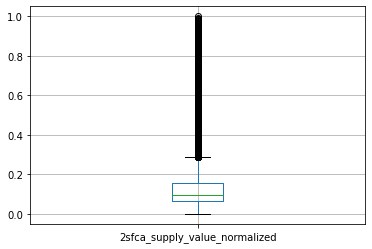

In [16]:
MSOA_fca.boxplot(column='2sfca_supply_value_normalized')

In [17]:
def plot_access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

### When the service radius is 10 miles driving distance:

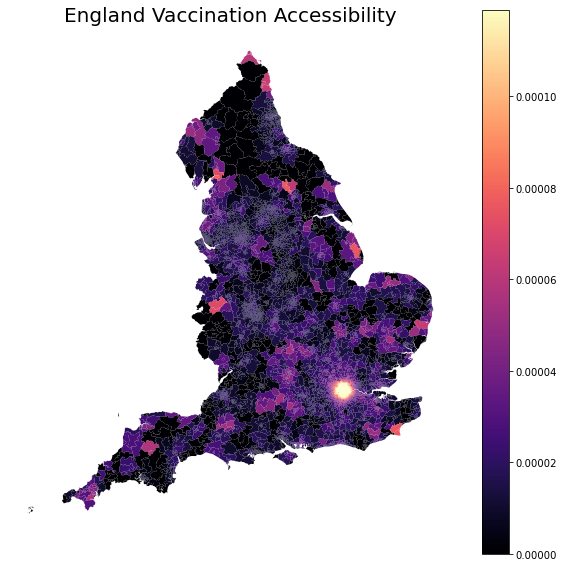

In [18]:
plot_access('2sfca_supply_value')

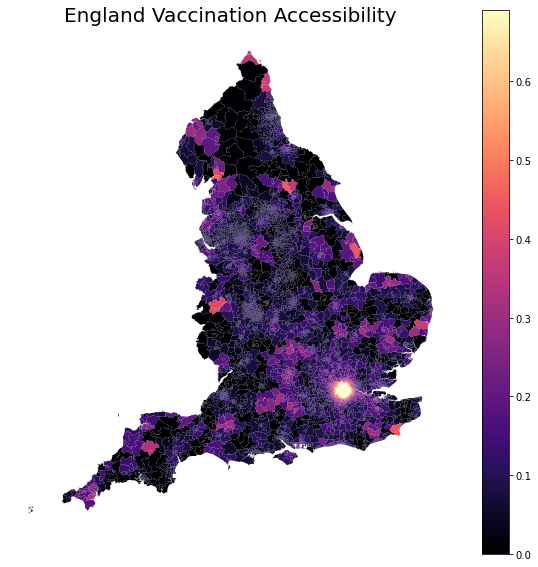

In [19]:
plot_access('2sfca_supply_value_normalized')

## Another way to visulize

In [20]:
def combo(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False
        )

### When the service radius is 10 miles:

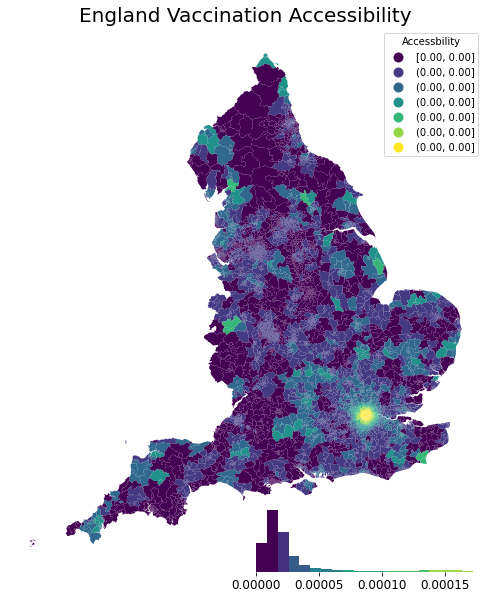

In [21]:
combo('2sfca_supply_value')

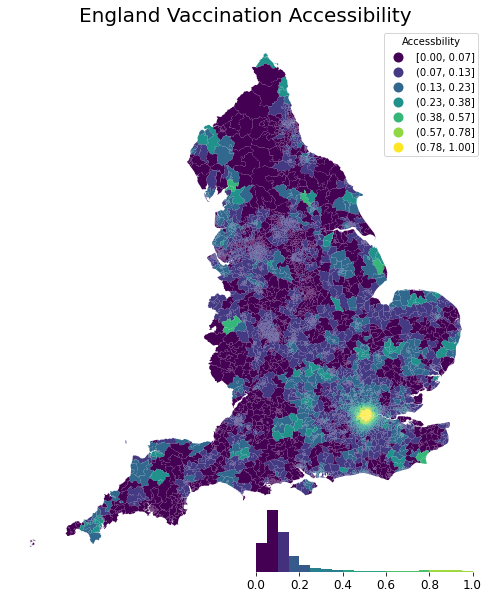

In [22]:
combo('2sfca_supply_value_normalized')

# Plot the vaccination population map

In [23]:
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_2_21.csv'
vaccination_pop = pd.read_csv(url)
vaccination_pop

,MSOA_code,under_70,over70-74,over75-79,over80,total
0,E02002796,1083,424,347,450,2304
1,E02002797,1141,516,463,854,2974
2,E02002798,1740,503,307,369,2919
3,E02002799,981,203,156,233,1573
4,E02002800,1091,372,293,516,2272
...,...,...,...,...,...,...
6786,E02002478,846,269,194,208,1517
6787,E02002479,1320,467,428,437,2652
6788,E02002480,817,304,267,317,1705
6789,E02002481,1002,303,225,364,1894


In [24]:
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

In [25]:
MSOA_fca['vaccination_percentage'] = MSOA_fca['total']/MSOA_fca['population_y']
MSOA_fca.head(2)

,MSOA11CD,MSOA11NM,population_x,geometry,population_y,2sfca_supply_value,2sfca_supply_value_normalized,MSOA_code,under_70,over70-74,over75-79,over80,total,vaccination_percentage
0,E02000001,City of London 001,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",9721,0.000167,0.968732,E02000001,846,295,194,241,1576,0.162123
1,E02000002,Barking and Dagenham 001,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",7735,0.000030,0.174058,E02000002,778,163,156,294,1391,0.179832


In [26]:
def plot_access1(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Percentage', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

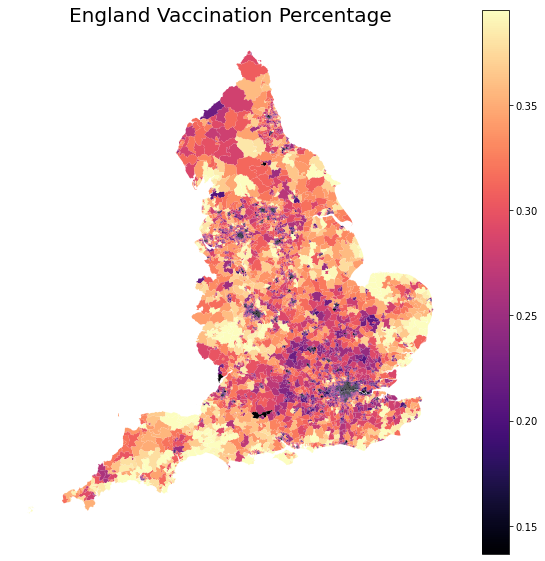

In [27]:
plot_access1('vaccination_percentage')

# Compare with accessibility score map

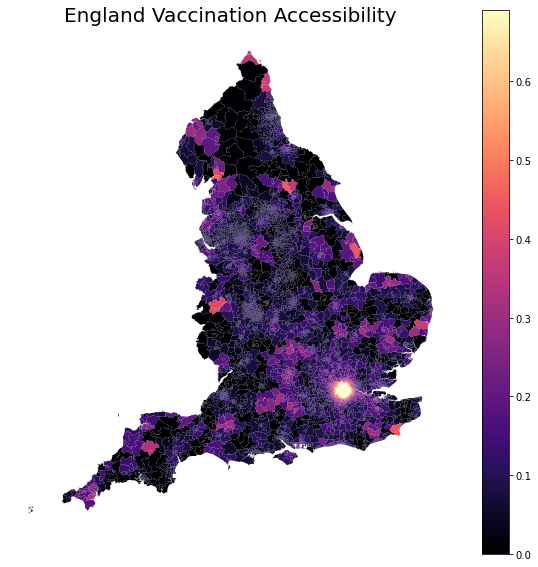

In [28]:
plot_access('2sfca_supply_value_normalized')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

In [36]:
pearson_correlation_coefficient = MSOA_fca[['2sfca_supply_value_normalized','vaccination_percentage']].corr(method='pearson')
pearson_correlation_coefficient

,2sfca_supply_value_normalized,vaccination_percentage
2sfca_supply_value_normalized,1.00000,-0.41732
vaccination_percentage,-0.41732,1.00000


In [37]:
spearman_correlation_coefficient = MSOA_fca[['2sfca_supply_value_normalized','vaccination_percentage']].corr(method='spearman')
spearman_correlation_coefficient

,2sfca_supply_value_normalized,vaccination_percentage
2sfca_supply_value_normalized,1.000000,-0.319757
vaccination_percentage,-0.319757,1.000000


# draw a scatter plot between accessibility and vaccination rate

In [ ]:
plot = pd.DataFrame()
plot['Accessibility'] = MSOA_fca['2sfca_supply_value_normalized']
plot['Vaccination Rate'] = MSOA_fca['vaccination_percentage']

Text(0, 0.5, 'Vaccination Rate')

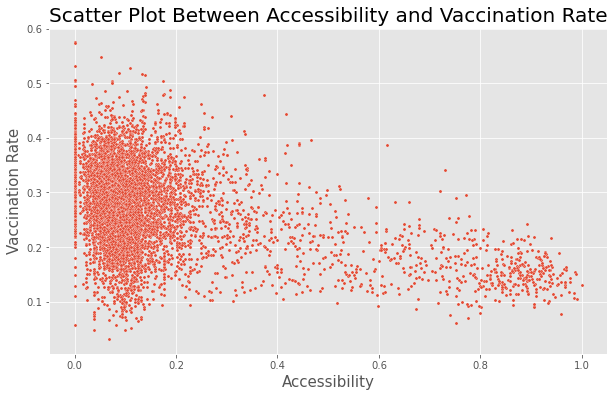

In [153]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
a = sns.scatterplot(data=plot, x="Accessibility", y="Vaccination Rate",s=10)
a.axes.set_title("Scatter Plot Between Accessibility and Vaccination Rate",fontsize=20)
a.set_xlabel("Accessibility",fontsize=15)
a.set_ylabel("Vaccination Rate",fontsize=+15)

Text(0.55, 1.05, 'Pair Plot Between Accessibility and Vaccination Rate')

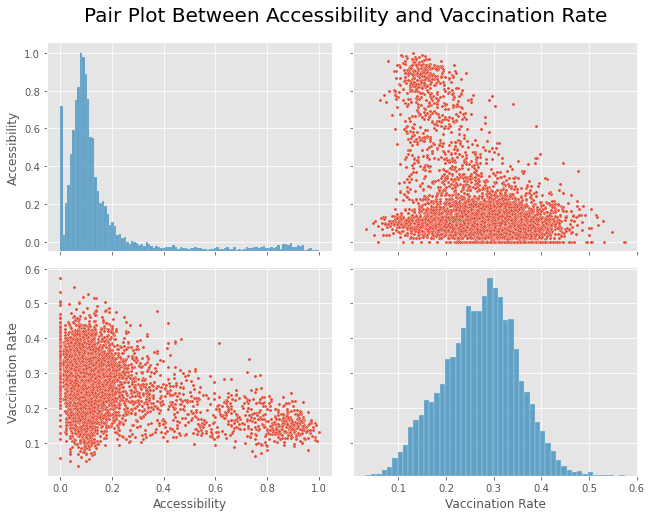

In [134]:
g = sns.pairplot(plot,plot_kws={"s": 10})
g.fig.set_size_inches(10,7)
g.fig.suptitle("Pair Plot Between Accessibility and Vaccination Rate", y=1.05,x=0.55,fontsize=20)
#g.plot_kws={"s": 1}

Text(0, 0.5, 'Vaccination Rate')

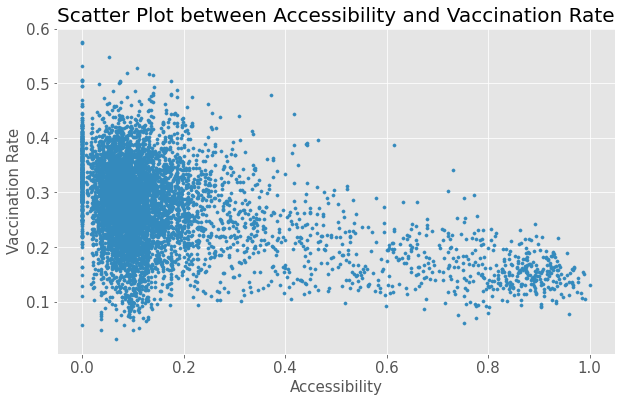

In [152]:
ax1 = plot.plot.scatter(x='Accessibility',
                        y='Vaccination Rate',
                        figsize = (10,6),
                        fontsize = 15,s=10)
plt.title("Scatter Plot between Accessibility and Vaccination Rate",fontsize=20)
plt.xlabel("Accessibility",fontsize=15)
plt.ylabel("Vaccination Rate",fontsize=15)